In [1]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
from torchvision import datasets, transforms, models 
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data_dir = 'medical'
classes = os.listdir(data_dir)


In [3]:
train_transform=transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(60),             # resize shortest side to 100 pixels
        transforms.CenterCrop(60),         # crop longest side to 100 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
])

In [4]:
dataset = ImageFolder(data_dir, transform=train_transform)
print('Size of training dataset :', len(dataset))

Size of training dataset : 58954


In [5]:
# view one image shape of the dataset.
img, label = dataset[100]
print(img.shape)

torch.Size([3, 60, 60])


In [6]:
# function for the showing the image.
def show_image(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  AbdomenCT (0)


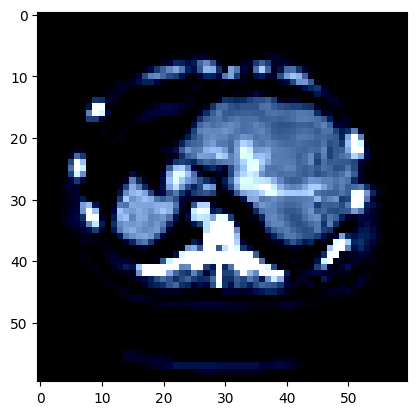

In [7]:
show_image(*dataset[200])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  AbdomenCT (0)


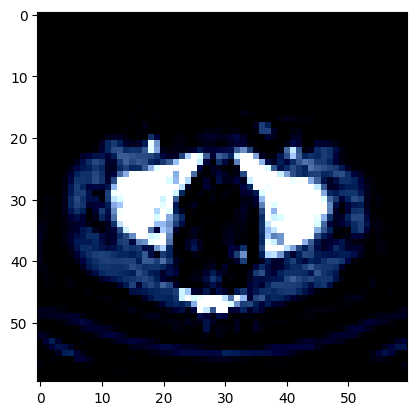

In [8]:
show_image(*dataset[500])

In [9]:
torch.manual_seed(20)
val_size = len(dataset)//10
test_size = len(dataset)//5
train_size = len(dataset) - val_size -test_size

In [10]:
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
len(train_ds), len(val_ds),len(test_ds)   

(41269, 5895, 11790)

In [11]:
batch_size = 64
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size*2, num_workers=4, pin_memory=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


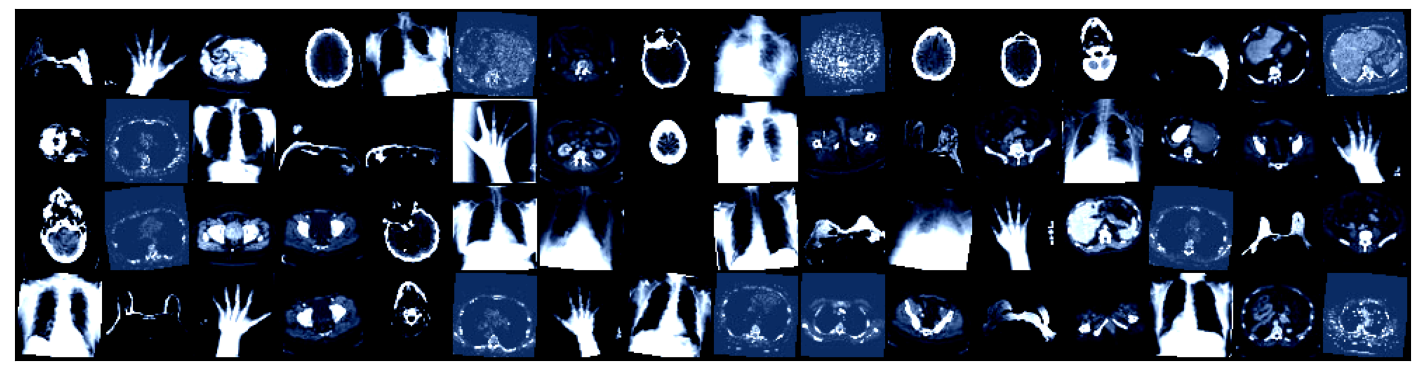

In [12]:
for images, labels in train_loader:
    fig, ax = plt.subplots(figsize=(18,10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
    break

In [13]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [14]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [15]:
torch.cuda.is_available()

True

In [16]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [17]:
device = get_default_device()
device

device(type='cuda')

In [18]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [19]:
input_size = 3*60*60
output_size = 7 # Number of class +1


In [20]:
class Model(ImageClassificationBase):
    def __init__(self, input_size, output_size):
        super().__init__()
        # hidden layer
        self.in_layer = nn.Linear(input_size, 8384)
        self.hidden1 = nn.Linear(8384, 4192)
        self.hidden2 = nn.Linear(4192, 2096)
        self.hidden3 = nn.Linear(2096, 1048)
        self.out_layer = nn.Linear(1048, output_size)
        
    def forward(self, xb):
        # Flatten images into vectors
        out = xb.view(xb.size(0), -1)
        out = self.in_layer(out)
        out = self.hidden1(F.relu(out))
        out = self.hidden2(F.relu(out))
        out = self.hidden3(F.relu(out))
        out = self.out_layer(F.relu(out))
        return out

In [21]:
model = to_device(Model(input_size, output_size), device)

In [22]:
model

Model(
  (in_layer): Linear(in_features=10800, out_features=8384, bias=True)
  (hidden1): Linear(in_features=8384, out_features=4192, bias=True)
  (hidden2): Linear(in_features=4192, out_features=2096, bias=True)
  (hidden3): Linear(in_features=2096, out_features=1048, bias=True)
  (out_layer): Linear(in_features=1048, out_features=7, bias=True)
)

In [23]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 1.941784143447876, 'val_acc': 0.07900360971689224}]

In [24]:
history += fit(7, 0.01, model, train_loader, val_loader)

  0%|          | 0/645 [00:00<?, ?it/s]

Epoch [0], train_loss: 0.3113, val_loss: 0.0560, val_acc: 0.9822


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch [1], train_loss: 0.0433, val_loss: 0.0231, val_acc: 0.9955


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.0270, val_loss: 0.0174, val_acc: 0.9947


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.0192, val_loss: 0.0134, val_acc: 0.9962


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.0153, val_loss: 0.0121, val_acc: 0.9963


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch [5], train_loss: 0.0124, val_loss: 0.0081, val_acc: 0.9973


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch [6], train_loss: 0.0100, val_loss: 0.0078, val_acc: 0.9975


In [25]:
history += fit(8, 0.001, model, train_loader, val_loader)

  0%|          | 0/645 [00:00<?, ?it/s]

Epoch [0], train_loss: 0.0072, val_loss: 0.0064, val_acc: 0.9982


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch [1], train_loss: 0.0075, val_loss: 0.0059, val_acc: 0.9982


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.0072, val_loss: 0.0067, val_acc: 0.9982


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.0070, val_loss: 0.0063, val_acc: 0.9985


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.0070, val_loss: 0.0061, val_acc: 0.9987


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch [5], train_loss: 0.0067, val_loss: 0.0060, val_acc: 0.9990


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch [6], train_loss: 0.0069, val_loss: 0.0063, val_acc: 0.9987


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch [7], train_loss: 0.0063, val_loss: 0.0059, val_acc: 0.9988


In [26]:
history += fit(3, 0.0001, model, train_loader, val_loader)

  0%|          | 0/645 [00:00<?, ?it/s]

Epoch [0], train_loss: 0.0069, val_loss: 0.0061, val_acc: 0.9982


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch [1], train_loss: 0.0065, val_loss: 0.0069, val_acc: 0.9980


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.0065, val_loss: 0.0055, val_acc: 0.9988


In [27]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    plt.show()
    
    
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    plt.show()

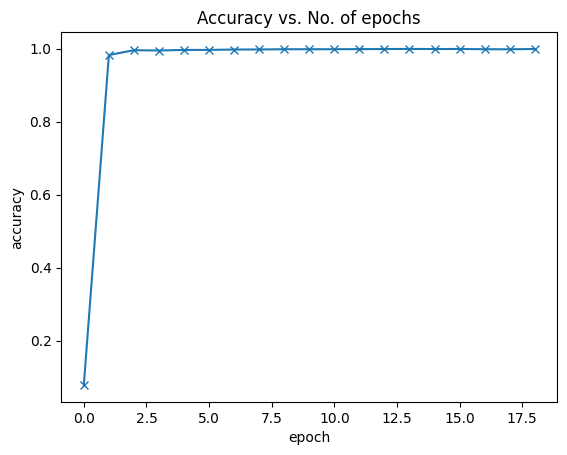

In [28]:
plot_accuracies(history)


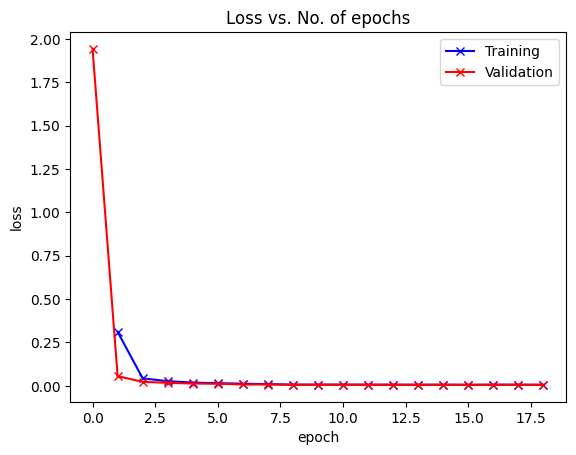

In [29]:
plot_losses(history)


In [30]:
evaluate(model, test_loader)

{'val_loss': 0.0065374914556741714, 'val_acc': 0.9982358813285828}

In [31]:
model.eval()
y_true=[]
y_pred=[]
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())
print(y_pred[0:5])

[5, 4, 0, 1, 2]


In [32]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: AbdomenCT , Predicted: AbdomenCT


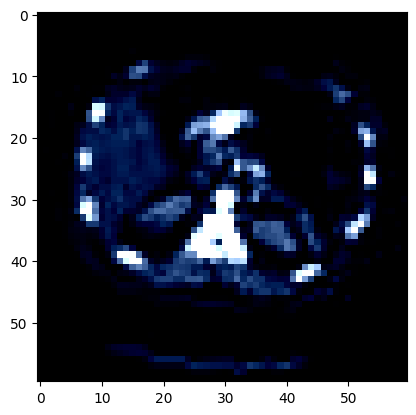

In [33]:
img, label = dataset[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: Hand , Predicted: Hand


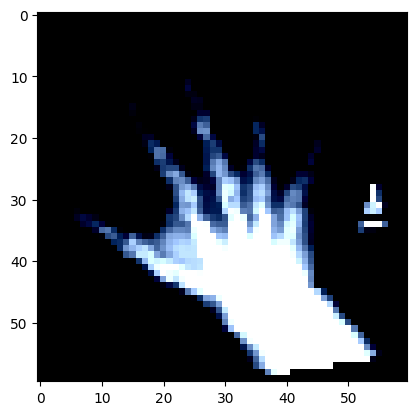

In [36]:
img, label = dataset[45222]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))